In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy as sp
import scipy.optimize
import scipy.stats
import scipy.sparse
import collections
import pandas as pd
%matplotlib inline


l2 = np.linalg.norm

## Set the working directory

Here a dump rule is used to find the notebook directory via linux `pwd` command. It may fail or get wrong result in some cases. 
See [this discussion](https://github.com/ipython/ipython/issues/10123) for more details.

In [2]:
WORK_DIR = !pwd
WORK_DIR = WORK_DIR[0]
print(WORK_DIR)

/home/obus/PhD/code/ProjOptim/For PhD thesis/optimus/notebooks


## Add optimus package sources to the path
This one: https://github.com/Obus/optimus/

In [3]:
optimus_sources_path = os.path.join(WORK_DIR, '../src')
sys.path = list(set(sys.path) | {optimus_sources_path})

## Read DOROTHEA data

### Set the data folder

In [4]:
DATA_DIR = os.path.join(WORK_DIR, 'data', 'dorothea')

In [5]:
!mkdir -p "{DATA_DIR}"
!ls -l "{DATA_DIR}"

total 0


### If the folder is empty, download the data

In [6]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.data -O "{DATA_DIR}/dorothea_train.data"
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.labels -O "{DATA_DIR}/dorothea_train.labels"
!ls -l "{DATA_DIR}"

--2019-10-11 13:57:03--  http://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4287039 (4,1M) [application/x-httpd-php]
Saving to: ‘/home/obus/PhD/code/ProjOptim/For PhD thesis/optimus/notebooks/data/dorothea/dorothea_train.data’

/home/obus/PhD/code 100%[===================>]   4,09M   647KB/s    in 11s     

2019-10-11 13:57:16 (367 KB/s) - ‘/home/obus/PhD/code/ProjOptim/For PhD thesis/optimus/notebooks/data/dorothea/dorothea_train.data’ saved [4287039/4287039]

--2019-10-11 13:57:16--  http://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.labels
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connec

### Verify that files hashes matches

In [8]:
import hashlib
expected_hashes = {
    'dorothea_train.data': '2c8b22b217edc5f61b1b0f77242005a5',
    'dorothea_train.labels': '8e243786c097eb6a5a3bce3fce9d94aa',
}
for file_name, expected_hash in expected_hashes.items():
    with open(os.path.join(DATA_DIR, file_name), 'rb') as f:
        assert expected_hash == hashlib.md5(f.read()).hexdigest(), (
            f'unexpected hash for {file_name} file, please check that it was downloaded correctly'
        )

In [9]:
def read_dorothea_data(data_path):
    d = 100000 + 1
    row = []
    col = []
    data = []
    with open(data_path, 'r') as f:
        for ir, line in enumerate(f):
            line = line.strip()
            for ic in line.split(' '):
                row.append(ir)
                col.append(int(ic) - 1)
                data.append(1)
            row.append(ir)
            col.append(d - 1)
            data.append(1)
    return scipy.sparse.csr_matrix((data, (row, col)), shape=(ir + 1, d))


def read_dorothea_labels(labels_path):
    return pd.read_csv(labels_path,  sep=' ',  names=['y']).iloc[:, 0].values

train_data = read_dorothea_data(os.path.join(DATA_DIR, 'dorothea_train.data'))
train_labels = read_dorothea_labels(os.path.join(DATA_DIR, 'dorothea_train.labels'))
print(collections.Counter(train_labels))
train_data

Counter({-1: 722, 1: 78})


<800x100001 sparse matrix of type '<class 'numpy.int64'>'
	with 728560 stored elements in Compressed Sparse Row format>

## Set up target function and gradient

In [10]:
Phi = train_data
d = Phi.shape[1]
Y = (train_labels > 0) * 1


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def func(x):
    h = sigmoid(Phi.dot(x))
    f = sum(- Y * np.log(h) - (1 - Y) * np.log(1 - h)) / Phi.shape[0]
    if np.isnan(f):
        return np.infty
#     if np.isinf(f):
#         return np.infty
    return f


def grad(x):
    h = sigmoid(Phi.dot(x))
    return (Phi.T.dot(h - Y)) / Phi.shape[0]


func(np.random.normal(size=d) / 10000)

0.6928337361423034

## Compare optimizers on a single run

In [11]:
from optimus.cg import CG, BealePowellCG
from optimus.bfgs import LBFGS
from optimus.sso import LQNSSO_CG

optimizers = [
    LBFGS(dim=d, subspace_dim=2),
    LBFGS(dim=d, subspace_dim=3),
    LBFGS(dim=d, subspace_dim=5),
    LBFGS(dim=d, subspace_dim=10),
    LQNSSO_CG(subspace_dim=2, dim=d),
    LQNSSO_CG(subspace_dim=3, dim=d),
    LQNSSO_CG(subspace_dim=5, dim=d),
    LQNSSO_CG(subspace_dim=10, dim=d),
    CG(restart=None),
    BealePowellCG(dim=d),
]
for opt in optimizers:
    print(opt)

LBFGS(line_search=ScalarLS(method=brent), subspace_dim=2)
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=3)
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=5)
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=10)
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=2)
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=3)
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=5)
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=10)
CG(line_search=ScalarLS(method=brent), restart=None)
BealePowellCG(line_search=ScalarLS(method=brent), c1=0.2, c2=0.8, c3=1.2)


In [12]:
import collections
import tqdm
x0 = np.random.normal(size=d, scale=1e-3)

errors_dict = collections.defaultdict(list)
max_num_steps = 100
for opt in tqdm.tqdm_notebook(optimizers):
    x = np.copy(x0)
    errors_dict[str(opt)] = []
    fx1 = 1e10
    cnt = 0
    for i in tqdm.tqdm_notebook(range(max_num_steps), desc=str(opt)):
        try:
            fx = func(x)
            if i % 10 == 0:
                print(i, fx)
            if np.isnan(fx) or not np.isfinite(fx):
                break
            if fx1 == fx:
                cnt += 1
                if cnt > 50:
                    break
            fx1 = fx
            errors_dict[str(opt)].append(fx)# l2(x - x_star))
            x = opt.step(x, func, grad)
        except Exception as e:
            print(f'Optimizer {opt} failed in iteration {i} with exc: {e}')
            raise
    

0 0.69453243570451


/home/obus/venv/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/obus/venv/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/home/obus/venv/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/obus/PhD/code/ProjOptim/For PhD thesis/optimus/notebooks/../src/optimus/bfgs.py:72: RuntimeWarning: invalid value encountered in double_scalars
  gamma = s.dot(y) / y.dot(y)


0 0.69453243570451


0 0.69453243570451


0 0.69453243570451


0 0.69453243570451


/home/obus/venv/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


10 0.0001489066596393875
20 2.4139852604048504e-06
30 2.4139852604048504e-06
40 2.4139852604048504e-06
50 2.4139852604048504e-06
60 2.4139852604048504e-06


0 0.69453243570451
10 0.0006902650480652994


/home/obus/venv/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/obus/venv/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


20 1.820909806562084e-05
30 1.6383605682742014e-05
40 1.6383605682742014e-05
50 1.6383605682742014e-05
60 1.6383605682742014e-05
70 1.6383605682742014e-05


0 0.69453243570451
10 0.0006644960106729957
20 1.6718745308965042e-05
30 1.3259853544457216e-05
40 9.057965454090344e-06
50 9.057965453985134e-06
60 9.057965453985134e-06
70 9.057965453985134e-06


0 0.69453243570451
10 0.034014954132953405
20 0.00024913392841568923
30 5.2769005540301734e-05
40 2.839842598470045e-05
50 1.6883444381554064e-05
60 1.688344438155379e-05
70 1.6883444381543933e-05
80 1.683674713953476e-05


0 0.69453243570451
10 6.504512260350857e-06
20 2.69814843970504e-06
30 2.69814843970504e-06
40 2.69814843970504e-06
50 2.69814843970504e-06
60 2.69814843970504e-06


0 0.69453243570451


/home/obus/PhD/code/ProjOptim/For PhD thesis/optimus/notebooks/../src/optimus/cg.py:100: RuntimeWarning: invalid value encountered in double_scalars
  beta = gk.dot(yk1) / self.dk1.dot(yk1)


In [15]:
errors = pd.DataFrame({
    k: errors + [np.nan] * (max_num_steps - len(errors))  for k, errors in errors_dict.items()
})
errors.head(100)

,"LBFGS(line_search=ScalarLS(method=brent), subspace_dim=2)","LBFGS(line_search=ScalarLS(method=brent), subspace_dim=3)","LBFGS(line_search=ScalarLS(method=brent), subspace_dim=5)","LBFGS(line_search=ScalarLS(method=brent), subspace_dim=10)","LQNSSO_CG(line_search=ScalarLS(method=brent), sd=2)","LQNSSO_CG(line_search=ScalarLS(method=brent), sd=3)","LQNSSO_CG(line_search=ScalarLS(method=brent), sd=5)","LQNSSO_CG(line_search=ScalarLS(method=brent), sd=10)","CG(line_search=ScalarLS(method=brent), restart=None)","BealePowellCG(line_search=ScalarLS(method=brent), c1=0.2, c2=0.8, c3=1.2)"
0,0.694532,0.694532,0.694532,0.694532,0.694532,0.694532,0.694532,0.694532,0.694532,0.694532
1,0.278289,0.278289,0.278289,0.278289,0.278289,0.278289,0.278289,0.278289,0.278289,0.278289
2,0.075297,0.075297,0.075297,0.075297,0.075297,0.075297,0.075297,0.075297,0.075297,0.075297
3,0.057947,0.055293,0.055293,0.055293,0.057947,0.045724,0.045724,0.045724,0.057947,0.057947
4,0.057947,0.055293,0.055293,0.055293,0.034995,0.045724,0.045724,0.045724,0.033215,0.057947
5,NaN,NaN,NaN,NaN,0.008759,0.025662,0.043266,0.043266,0.014038,NaN
6,NaN,NaN,NaN,NaN,0.002902,0.010869,0.026031,0.034015,0.004393,NaN
7,NaN,NaN,NaN,NaN,0.000220,0.003412,0.002543,0.034015,0.000313,NaN
8,NaN,NaN,NaN,NaN,0.000172,0.001294,0.001189,0.034015,0.000027,NaN
9,NaN,NaN,NaN,NaN,0.000149,0.001147,0.000966,0.034015,0.000013,NaN


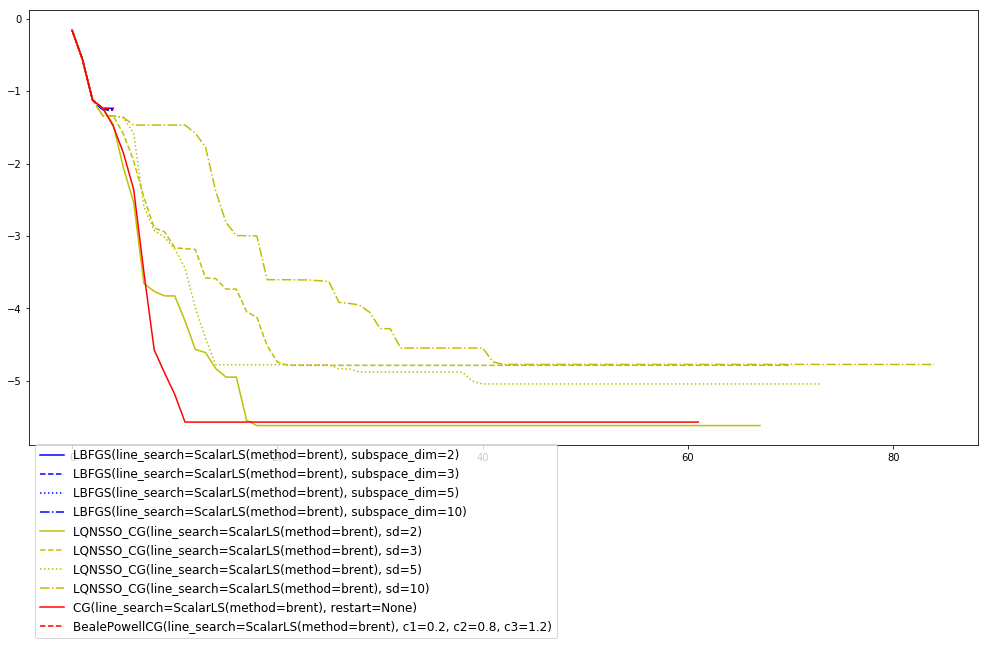

In [18]:
plt.rcParams["figure.figsize"] = (17,8)
linestyles = ['-', '--', ':',  '-.', ]
colors = ['b', 'y', 'r', 'g']#, 'purple', 'orange', 'darkblue']
styles = []
for i in range(len(errors.columns)):
    c = colors[i // len(colors)]
    ls = linestyles[i % len(colors)]
    styles.append(f'{c}{ls}')

np.log10(errors).iloc[:, :].plot(style=styles[:])
plt.legend(loc='center left', bbox_to_anchor=(0, -0.22), fontsize=12)
plt.show()

In [19]:
errors.min().sort_values()

LQNSSO_CG(line_search=ScalarLS(method=brent), sd=2)                          0.000002
CG(line_search=ScalarLS(method=brent), restart=None)                         0.000003
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=5)                          0.000009
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=3)                          0.000016
LQNSSO_CG(line_search=ScalarLS(method=brent), sd=10)                         0.000017
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=3)                    0.055293
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=5)                    0.055293
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=10)                   0.055293
LBFGS(line_search=ScalarLS(method=brent), subspace_dim=2)                    0.057947
BealePowellCG(line_search=ScalarLS(method=brent), c1=0.2, c2=0.8, c3=1.2)    0.057947
dtype: float64

## Compare optimizers on multiple runs

### Run optimizations `num_experiments` times 

In [14]:
import tqdm

num_experiments = 1000
max_num_steps = 100

errors_list = []
for experiment_ind in tqdm.tqdm_notebook(range(num_experiments)): 
    x0 = np.random.normal(size=d, scale=1e-5)

    errors_dict = collections.defaultdict(list)
    
    optimizers = [
        LBFGS(dim=d, subspace_dim=2),
        LBFGS(dim=d, subspace_dim=3),
        LBFGS(dim=d, subspace_dim=5),
        LBFGS(dim=d, subspace_dim=10),
        LQNSSO_CG(subspace_dim=2, dim=d),
        LQNSSO_CG(subspace_dim=3, dim=d),
        LQNSSO_CG(subspace_dim=5, dim=d),
        LQNSSO_CG(subspace_dim=10, dim=d),
        CG(restart=None),
        BealePowellCG(dim=d),
    ]
    for opt in optimizers:
        x = np.copy(x0)
        for i in range(max_num_steps):
            try:
                fx = func(x)
                if np.isnan(fx) or not np.isfinite(fx):
                    break
                if fx1 == fx:
                    cnt += 1
                    if cnt > 100:
                        break
                fx1 = fx
                errors_dict[str(opt)].append(fx)# l2(x - x_star))
                x = opt.step(x, func, grad)
            except Exception as e:
                print(f'Optimizer {opt} failed in iteration {i} with exc: {e}')
                break
                
    errors = pd.DataFrame({
        k: errors + [np.nan] * (max_num_steps - len(errors))  for k, errors in errors_dict.items()
    })
    errors_list.append(errors)

/home/obus/venv/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/obus/venv/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4
restart on step 2
restart on step 3
restart on step 4


KeyboardInterrupt: 

In [19]:
errors_min = pd.concat([e.min() for e in errors_list], axis=1)
errors_min

,0,1,2,3,4,5,6,7,8,9,10,11,12
"LBFGS(line_search=ScalarLS(method=brent), subspace_dim=2)",0.056044,0.056023,0.056055,0.056051,0.056020,0.056021,0.055992,0.056057,0.056037,0.056059,0.056039,0.056030,0.056037
"LBFGS(line_search=ScalarLS(method=brent), subspace_dim=3)",0.053444,0.053426,0.053453,0.053452,0.053421,0.053423,0.053396,0.053457,0.053437,0.053459,0.053441,0.053434,0.053438
"LBFGS(line_search=ScalarLS(method=brent), subspace_dim=5)",0.053444,0.053426,0.053453,0.053452,0.053421,0.053423,0.053396,0.053457,0.053437,0.053459,0.053441,0.053434,0.053438
"LBFGS(line_search=ScalarLS(method=brent), subspace_dim=10)",0.053444,0.053426,0.053453,0.053452,0.053421,0.053423,0.053396,0.053457,0.053437,0.053459,0.053441,0.053434,0.053438
"LQNSSO_CG(line_search=ScalarLS(method=brent), sd=2)",0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
"LQNSSO_CG(line_search=ScalarLS(method=brent), sd=3)",0.000013,0.043561,0.043583,0.043586,0.043551,0.043556,0.043528,0.043591,0.043567,0.043594,0.043576,0.043570,0.043571
"LQNSSO_CG(line_search=ScalarLS(method=brent), sd=5)",0.043576,0.043561,0.043583,0.043586,0.043551,0.043556,0.043528,0.043591,0.043567,0.043594,0.043576,0.043570,0.043571
"LQNSSO_CG(line_search=ScalarLS(method=brent), sd=10)",0.043576,0.043561,0.043583,0.043586,0.043551,0.043556,0.043528,0.043591,0.043567,0.043594,0.043576,0.043570,0.043571
"CG(line_search=ScalarLS(method=brent), restart=None)",0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
"BealePowellCG(line_search=ScalarLS(method=brent), c1=0.2, c2=0.8, c3=1.2)",0.056044,0.056023,0.056056,0.056051,0.056020,0.056021,0.055992,0.056057,0.056037,0.056059,0.056039,0.056030,0.056037


### Rename methods for better visualization

In [18]:
methods_renamings = {
    'BealePowellCG(line_search=ScalarLS(method=brent), c1=0.2, c2=0.8, c3=1.2)': 'BPCG',   
    'CG(line_search=ScalarLS(method=brent), restart=None)': 'CG'
}
for sd in (2, 3, 5, 10):
    methods_renamings[f'LBFGS(line_search=ScalarLS(method=brent), subspace_dim={sd})'] = (
        f'L-BFGS({sd})'
    )
    methods_renamings[f'LQNSSO_CG(line_search=ScalarLS(method=brent), sd={sd})'] = (
        f'L-QNSSO({sd})'
    )

errors_min.rename(index=methods_renamings, inplace=True)
errors_min

,index,0,1,2,3,4,5,6,7,8,9,10,11,12
0,L-BFGS(4),0.056044,0.056023,0.056055,0.056051,0.056020,0.056021,0.055992,0.056057,0.056037,0.056059,0.056039,0.056030,0.056037
1,"L-BFGS(line_search=ScalarLS(method=brent),3)",0.053444,0.053426,0.053453,0.053452,0.053421,0.053423,0.053396,0.053457,0.053437,0.053459,0.053441,0.053434,0.053438
2,L-BFGS(10),0.053444,0.053426,0.053453,0.053452,0.053421,0.053423,0.053396,0.053457,0.053437,0.053459,0.053441,0.053434,0.053438
3,L-BFGS(20),0.053444,0.053426,0.053453,0.053452,0.053421,0.053423,0.053396,0.053457,0.053437,0.053459,0.053441,0.053434,0.053438
4,"LQNSSO_CG(line_search=ScalarLS(method=brent),2)",0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
5,"LQNSSO_CG(line_search=ScalarLS(method=brent),3)",0.000013,0.043561,0.043583,0.043586,0.043551,0.043556,0.043528,0.043591,0.043567,0.043594,0.043576,0.043570,0.043571
6,"LQNSSO_CG(line_search=ScalarLS(method=brent),5)",0.043576,0.043561,0.043583,0.043586,0.043551,0.043556,0.043528,0.043591,0.043567,0.043594,0.043576,0.043570,0.043571
7,"LQNSSO_CG(line_search=ScalarLS(method=brent),10)",0.043576,0.043561,0.043583,0.043586,0.043551,0.043556,0.043528,0.043591,0.043567,0.043594,0.043576,0.043570,0.043571
8,CG,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
9,BealePowellCG(line_search=ScalarLS(method=bren...,0.056044,0.056023,0.056056,0.056051,0.056020,0.056021,0.055992,0.056057,0.056037,0.056059,0.056039,0.056030,0.056037


### Check the results

In [22]:
np.log(errors_min).median(axis=1).sort_values()

CG            -12.989164
L-QNSSO(2)    -12.862332
L-QNSSO(3)     -3.133380
L-QNSSO(5)     -3.133362
L-QNSSO(10)    -3.133362
L-BFGS(3)      -2.929224
L-BFGS(5)      -2.929224
L-BFGS(10)     -2.929224
BPCG           -2.881741
L-BFGS(2)      -2.881739
dtype: float64

In [23]:
np.log(errors_min).mean(axis=1).sort_values()

CG            -12.989508
L-QNSSO(2)    -12.886860
L-QNSSO(3)     -3.756859
L-QNSSO(5)     -3.133388
L-QNSSO(10)    -3.133388
L-BFGS(3)      -2.929252
L-BFGS(5)      -2.929252
L-BFGS(10)     -2.929252
L-BFGS(2)      -2.881765
BPCG           -2.881765
dtype: float64

In [24]:
def argsort_wo_ties(arr):
    return np.array([
        np.sum(a > arr)
        for a in arr
    ])

errors_min.apply(argsort_wo_ties, axis=0).sum(axis=1).sort_values()

CG               1
L-QNSSO(2)      12
L-QNSSO(3)      26
L-QNSSO(5)      27
L-QNSSO(10)     27
L-BFGS(3)       65
L-BFGS(5)       65
L-BFGS(10)      65
L-BFGS(2)      109
BPCG           112
dtype: int64

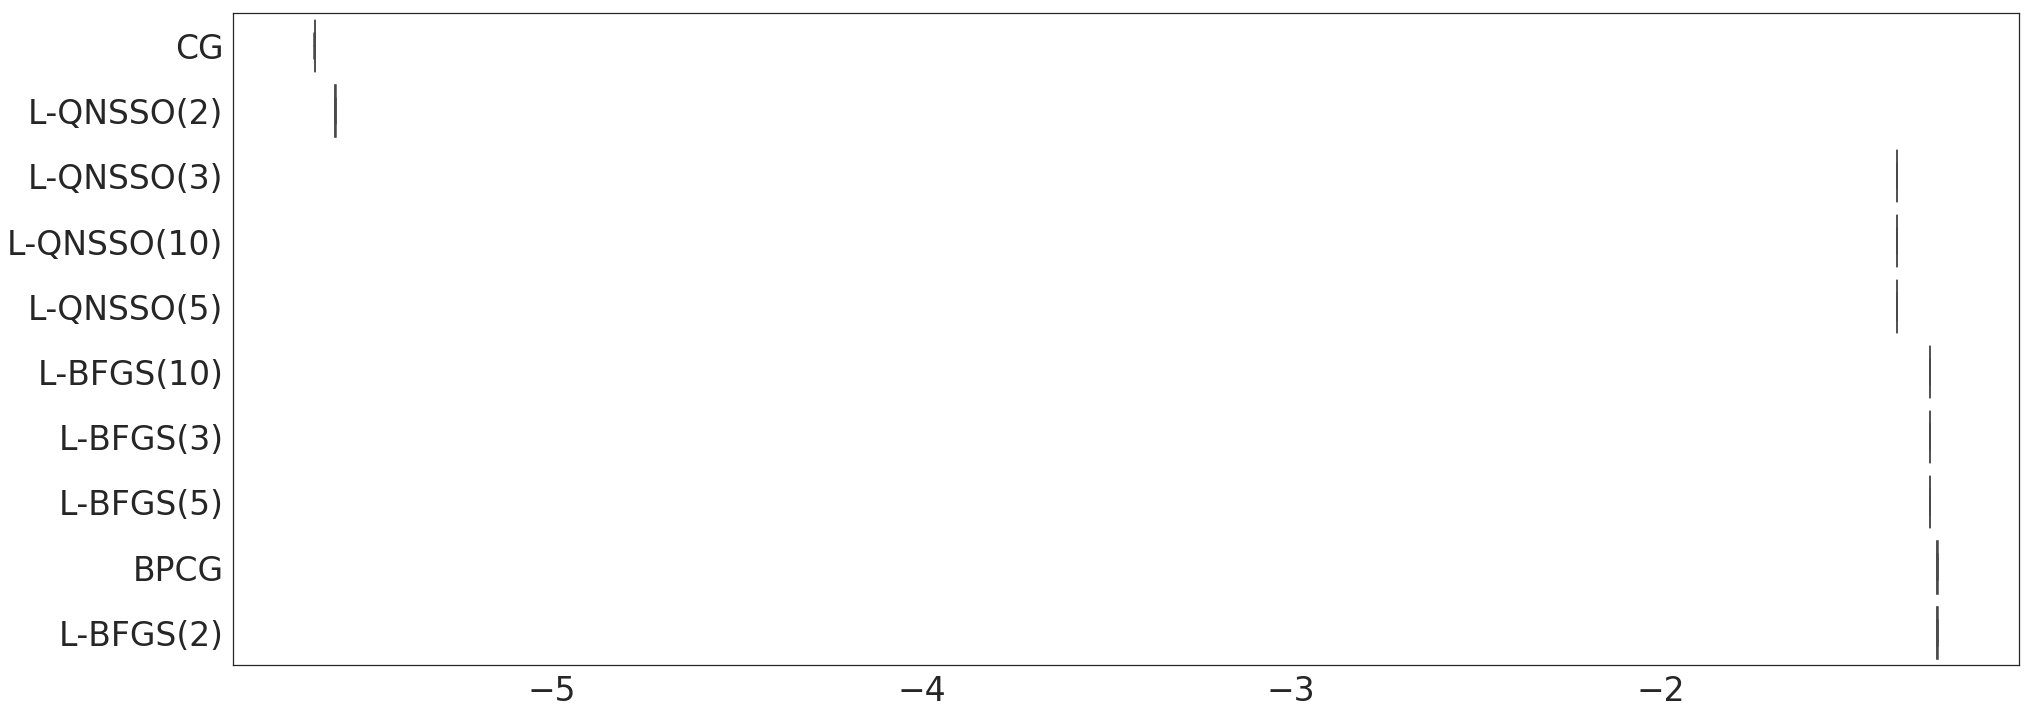

In [26]:
import seaborn as sns

errors_min_melted = (
    pd.melt(np.log10(errors_min).iloc[:,:].reset_index(), id_vars='index')
    .rename(columns={'index': 'method', 'value': 'target', 'variable': 'run_index'})
)
errors_median = (
    errors_min_melted
    .groupby('method')
    ['target'].median()
)

plt.figure(figsize=(32, 12))
sns.set(font_scale=3)
sns.set_style("white")
ax = sns.boxplot(
    y='method',
    x='target',
#     orient='v',
    data=errors_min_melted,
    order=errors_median.sort_values().index,
    sym='',
#     whis=100,
)
ax.set(xlabel='', ylabel='')
plt.show()